# Transfer Learning using VGG16 Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import seaborn as sns
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import callbacks
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

plt.rcParams['figure.figsize']= (20,8)

Transfer learning is the training of a pre-trained neural network which is already trained on a comparitively larger dataset and our dataset is much smaller

In [2]:
# prompt: mount my drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
batch_size = 32
img_size = 224

#directory = '/kaggle/input/animals10/raw-img'
directory = '/content/drive/MyDrive/AI_NNDL_Fall2024/Data/raw-img'
directory ='/content/drive/MyDrive/AIDL_data/animal_data'

datagen = ImageDataGenerator(rescale=1/255.,
                             zoom_range =0.2,
                             validation_split = 0.15,
                             horizontal_flip = True)

train_generator = datagen.flow_from_directory(directory,
                                                    target_size= (img_size, img_size),
                                                    batch_size = batch_size,
                                                    subset = 'training',
                                                    shuffle = True,
                                                    class_mode ='categorical')

val_generator = datagen.flow_from_directory(directory,
                                                target_size= (img_size, img_size),
                                                batch_size = batch_size,
                                                subset ='validation',
                                                shuffle = False,
                                                class_mode ='categorical')



Found 104 images belonging to 4 classes.
Found 16 images belonging to 4 classes.


# **Intel images dataset sample**

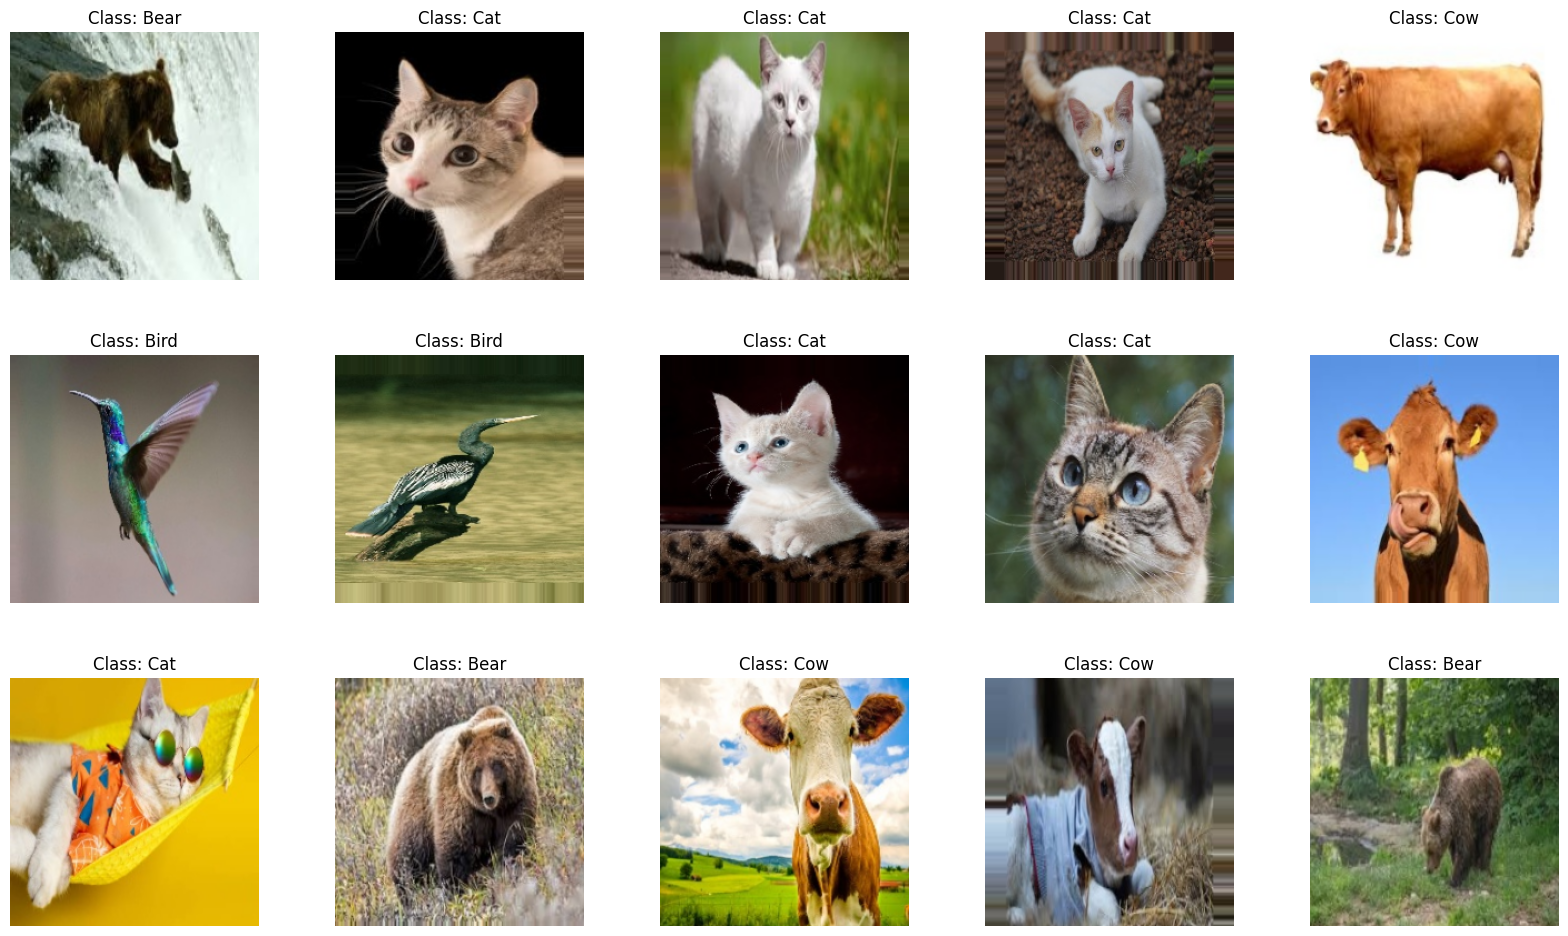

In [4]:
labels = [k for k in train_generator.class_indices]
sample_generate = train_generator.__next__()
images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20,20))

for i in range(15):
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(hspace=0.3,wspace=0.3)
    plt.imshow(images[i])
    plt.title(f'Class: {labels[np.argmax(titles[i],axis=0)]}')
    plt.axis('off')


In [5]:
img_size = 224
base_model = VGG16(include_top =False,
                  weights = 'imagenet',
                  input_shape=(img_size,img_size,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [6]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
base_model.layers

[<InputLayer name=input_layer, built=True>,
 <Conv2D name=block1_conv1, built=True>,
 <Conv2D name=block1_conv2, built=True>,
 <MaxPooling2D name=block1_pool, built=True>,
 <Conv2D name=block2_conv1, built=True>,
 <Conv2D name=block2_conv2, built=True>,
 <MaxPooling2D name=block2_pool, built=True>,
 <Conv2D name=block3_conv1, built=True>,
 <Conv2D name=block3_conv2, built=True>,
 <Conv2D name=block3_conv3, built=True>,
 <MaxPooling2D name=block3_pool, built=True>,
 <Conv2D name=block4_conv1, built=True>,
 <Conv2D name=block4_conv2, built=True>,
 <Conv2D name=block4_conv3, built=True>,
 <MaxPooling2D name=block4_pool, built=True>,
 <Conv2D name=block5_conv1, built=True>,
 <Conv2D name=block5_conv2, built=True>,
 <Conv2D name=block5_conv3, built=True>,
 <MaxPooling2D name=block5_pool, built=True>]

In [8]:
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [9]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [10]:
last_output = base_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense (512, activation = 'relu')(x)
outputs = Dense(4, activation = 'softmax')(x)
model = Model(inputs = base_model.inputs, outputs = outputs)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
model_name = 'model_TL.keras'

checkpoint = ModelCheckpoint(model_name, monitor='val_loss', mode = 'min',  verbose=1, save_best_only=True, save_weights_only=False)

es = EarlyStopping(monitor='val_loss', patience=5, min_delta=0, verbose = 1, restore_best_weights = True)

In [13]:
history = model.fit(train_generator,
                   epochs = 5,
                   validation_data = val_generator,
                   callbacks = [checkpoint, es])

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2765 - loss: 1.3892
Epoch 1: val_loss improved from inf to 1.15689, saving model to model_TL.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 89s 10s/step - accuracy: 0.3097 - loss: 1.3790 - val_accuracy: 0.6875 - val_loss: 1.1569
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.7171 - loss: 1.0680
Epoch 2: val_loss improved from 1.15689 to 0.81185, saving model to model_TL.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 57s 488ms/step - accuracy: 0.7179 - loss: 1.0556 - val_accuracy: 0.7500 - val_loss: 0.8119
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8112 - loss: 0.7537
Epoch 3: val_loss improved from 0.81185 to 0.59874, saving model to model_TL.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - accuracy: 0.8085 - loss: 0.7516 - val_accuracy: 0.7500 - val_loss: 0.5987
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9072 - loss: 0.4667
Epoch 4: val_loss improved from 0.59874 to 0.43381, saving model to model_TL.keras
4/4 ━━━━

In [14]:
history_df = pd.DataFrame(history.history)
history_df

,accuracy,loss,val_accuracy,val_loss
0,0.442308,1.337898,0.6875,1.156889
1,0.721154,1.006015,0.7500,0.811851
2,0.798077,0.743182,0.7500,0.598743
3,0.923077,0.410614,0.8750,0.433807
4,0.903846,0.305637,0.8750,0.295884


# Plotting accuracy and loss curves

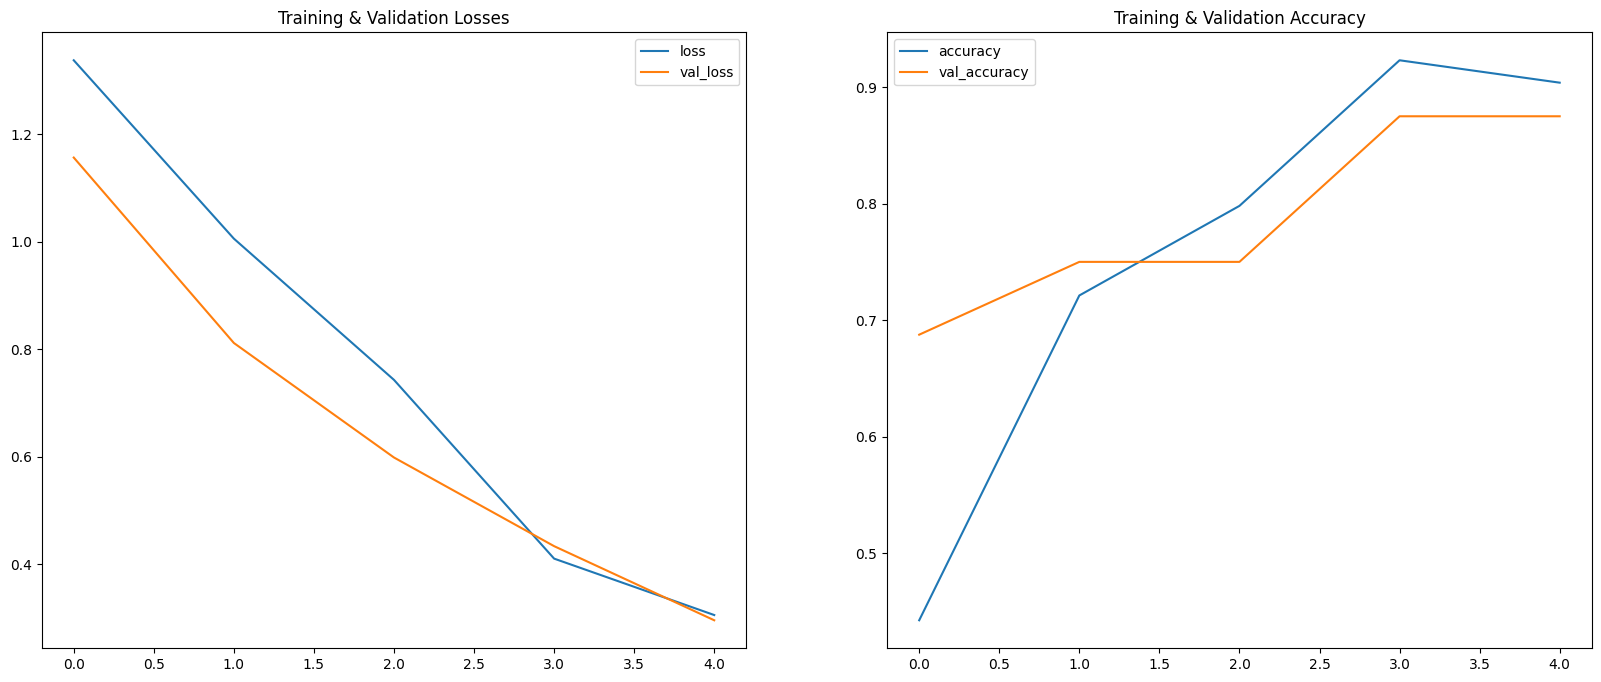

In [15]:
train_func = ['loss', 'accuracy']
valid_func = ['val_loss', 'val_accuracy']
titles = [
    'Training & Validation Losses',
    'Training & Validation Accuracy'
]

def plotting_training_result(histories, title, i=1):
    plt.subplot(1, 2, i)
    for hist in histories:
        plt.plot(range(history_df.shape[0]), history_df[hist], label=hist)
    plt.title(title, fontsize=12)
    plt.legend()

for i in range(len(train_func)):
    plotting_training_result([train_func[i], valid_func[i]], title=titles[i], i=i+1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
The predicted label for the image is: Bear


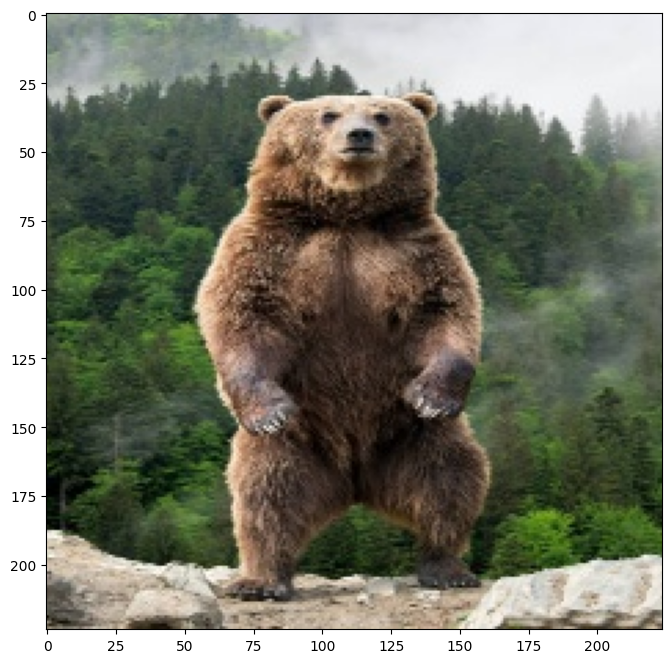

In [18]:
# prompt: using model predict an image

from tensorflow.keras.preprocessing import image
import numpy as np

def predict_image(image_path):
  img = image.load_img(image_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x / 255.0  # Rescale the image
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  predicted_class = np.argmax(classes)
  return labels[predicted_class]


# Example usage:
image_path = '/content/drive/MyDrive/AIDL_data/animal_data/Bear/Bear_10.jpg' # Replace with the actual path

img = image.load_img(image_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0  # Rescale the image
images = np.vstack([x])
classes = model.predict(images, batch_size=10)
predicted_class = np.argmax(classes)
predicted_label =labels[predicted_class]
print(f"The predicted label for the image is: {predicted_label}")
plt.imshow(img)